In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Importing libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set(rc={"figure.figsize":(12,10)})

import warnings
warnings.filterwarnings("ignore")

In [3]:
import random
# Make sure that on rerunning the code the results are reproducable
random.seed(101)

## Loading Data

In [4]:
data_train = pd.read_csv("/kaggle/input/titanic/train.csv")
data_test  = pd.read_csv("/kaggle/input/titanic/test.csv")

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Considering 2 paramters gender and pclass
dict_live = {
    0:'Died',
    1:'Survived'
}

dict_sex = {
    'male':0,
    'female':1
}
# Binary sex parameter
# Take each values in sex column and convert them into numarical values as defined in dict_sex
data_train['Bsex'] = data_train['Sex'].apply(lambda x: dict_sex[x])
data_test['Bsex']  = data_test['Sex'].apply(lambda x: dict_sex[x])

# features
x_train = data_train[['Pclass','Bsex']].to_numpy() # Converting into numpy array
y_train   = data_train['Survived'].to_numpy() 

x_test = data_test[['Pclass','Bsex']].to_numpy() # Converting into numpy array

In [7]:
x_test.shape

(418, 2)

## Multi Layer Perceptron

### Activation function and Derivation

In [8]:
# Sigmoid
def sigmoid(x,derivative = False):
    f = 1/(1+np.exp(-x))
    if derivative == True:
        return f * (1 - f)
    else:
        return f

def ReLU(x,derivative=False):
    if derivative == True:
        f = np.heaviside(x,1)
    else:
        f = np.maximum(x,0)
        
    return f

### Training ANN Model

In [9]:
x_train.shape

(891, 2)

In [10]:
# Pass 4 perceptron is 1st hidden unit
def train_ANN(x_train,y_train,h1_units=4,h2_units=4,learning_rate=0.00015):
    random.seed(101)
    # Preparing hidden layers
    # Hidden layer 1
    # no_of_perceptron * no_of_input_features
    w1 = 2*np.random.rand(h1_units,x_train.shape[1])
    b1 = np.random.randn(h1_units)
    
    # hidden layer 2
    # no_of_percptron in current layer * no_of_features from previous layer
    w2 = 2*np.random.randn(h2_units,h1_units)
    b2 = np.random.randn(h2_units)
    
    # output layer
    # weights from previous layer as input
    w_out = 2*np.random.randn(h2_units)
    b_out = np.random.randn(1)
    
    # Feed - Forward Network
    loss = []
    vec_y =[]
    
    for i in range(0,x_train.shape[0]):
        x_data = x_train[i]
        
        # wx + b
        h1 = ReLU(np.dot(w1,x_data) + b1) # hidden layer 1 output
        h2 = ReLU(np.dot(w2,h1)     + b2) # hidden layer 2 output
        y  = sigmoid(np.dot(w_out,h2)+ b_out) # output of the output layer
        
        # Back Propogate - calculate the layer derivatives
        delta_out = (y-y_train[i]) *  sigmoid(y,derivative = True)
        delta_2   = delta_out + w_out * ReLU(h2,derivative = True)
        delta_1   = np.dot(delta_2,w2)* ReLU(h1,derivative = True) 
        
        # Gradient Descent
        w_out = w_out - learning_rate * delta_out * h2 #output layer
        b_out = b_out - learning_rate * delta_out
        
        # Hidden layer 2
        w2 = w2 - learning_rate * np.kron(delta_2,h1).reshape(h2_units,h1_units)
        b2 = b2 - learning_rate * delta_2
        
        # Hidden layer 1
        w1 = w1 - learning_rate * np.kron(delta_1,x_data).reshape(h1_units,x_data.shape[0])
        b1 = b1 - learning_rate * delta_1
        
        # cost
        loss.append((1/2)* (y-y_train[i])**2)
        vec_y.append(y[0])
    
    # Storing the loss after every 60 instances and taking the average of the loss
    batch_loss = []
    for i in range(0,10):
        loss_avg = 0
        for m in range(0,60):
            loss_avg += vec_y[60*i + m ]/60
        batch_loss.append(loss_avg)
        
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(1,len(batch_loss)+1),batch_loss)
    plt.title("Average loss by epoch",fontsize=20)
    plt.xlabel("Epoch :",fontsize=16)
    plt.ylabel("Loss :",fontsize=16)
    plt.show()
    
    return w1,b1,w2,b2,w_out,b_out,loss

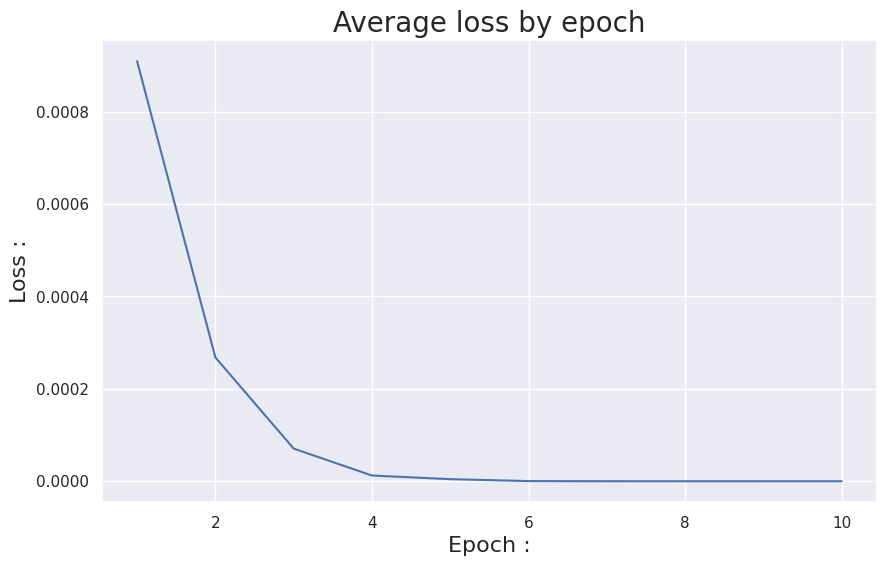

In [11]:
w1,b1,w2,b2,w_out,b_out,loss = train_ANN(x_train,y_train)

## Testing Module

In [12]:
def ANN_pred(x_test,w1,b1,w2,b2,w_out,b_out):
    
    pred = []
    
    for i in range(0,x_test.shape[0]):
        x = x_test[i]
        
        # wx + b
        z1 = ReLU(np.dot(w1,x) + b1) # hidden layer 1 output
        z2 = ReLU(np.dot(w2,z1)+ b2) # hidden layer 2 output
        y  = sigmoid(np.dot(w_out,z2)+ b_out) # output of the output layer
        
        pred.append(np.heaviside(y-0.5,1)[0])
        
    return np.array(pred)

In [13]:
predictions = ANN_pred(x_test,w1,b1,w2,b2,w_out,b_out)

## Model Evaluation

In [14]:
# from sklearn.metrics import accuracy_score,confusion_matrix
# cm = confusion_matrix(y_test,predictions)

# df_cm = pd.DataFrame(cm,index=[dict_live[i] for i in range(0,2)],
#                     columns = [dict_live[i] for i in range(0,2)])

In [15]:
# plt.figure(figsize=(7,7))
# sns.heatmap(df_cm,annot=True,cmap=plt.cm.Blues,fmt='g')
# plt.xlabel("Predicted Class",fontsize=18)
# plt.ylabel("True Class",fontsize=18)
# plt.show()

# accuracy_score(y_test,predictions)